<a href="https://colab.research.google.com/github/tensorflow-project/FineTuning/blob/main/four_emotions/training_four_emotions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
get_ipython().system('pip install -q git+https://github.com/keras-team/keras-cv.git')
get_ipython().system('pip install -q tensorflow==2.11.0')
get_ipython().system('pip install pyyaml h5py')

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 588.3/588.3 MB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 50.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 82.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 106.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 439.2/439.2 KB 40.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 106.9 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!git clone https://github.com/tensorflow-project/FineTuning

Cloning into 'FineTuning'...
remote: Enumerating objects: 2228, done.
remote: Counting objects: 100% (2228/2228), done.
remote: Compressing objects: 100% (696/696), done.
remote: Total 2228 (delta 1619), reused 2071 (delta 1505), pack-reused 0
Receiving objects: 100% (2228/2228), 238.09 MiB | 18.32 MiB/s, done.
Resolving deltas: 100% (1619/1619), done.


In [ ]:
import sys
import os
from google.colab import drive
import numpy as np
import keras
import tensorflow as tf
import urllib.request

drive.mount("/content/drive")

py_file_location = "/content/FineTuning/four_emotions"
sys.path.append(os.path.abspath(py_file_location))
py_file_location = "/content/FineTuning/models"
sys.path.append(os.path.abspath(py_file_location))

import textual_inversion_four_emotions as txt

Mounted at /content/drive
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
### create an instance of the StableDiffusion() class
stable_diffusion = txt.StableDiffusion()

### our new concept which is later inserted in the different prompts (for training and image generation).
###The goal is to create an embedding for our placeholder_token
placeholder_token = "<my-broccoli-token>"


### Add our placeholder_token to our stable_diffusion Model
stable_diffusion.tokenizer.add_tokens(placeholder_token)

train_ds = txt.create_dataset(stable_diffusion, placeholder_token)

### beta is the diffusion rate 
noise_scheduler = txt.NoiseScheduler(
    ### beta_start determines the amount of noise added at the start of the denoising process
    beta_start=0.00085,
    ### beta_end at the end of the denoising process
    beta_end=0.012,
    ### the beta_schedule determines that the diffusion rate increases linearly
    beta_schedule="scaled_linear",
    train_timesteps=1000,
)

training_image_encoder = keras.Model(
        stable_diffusion.image_encoder.input,
        stable_diffusion.image_encoder.layers[-2].output,
    )
    
  
### inizialize the optimizer
optimizer = tf.keras.optimizers.Adam(
    weight_decay=0.004, learning_rate=1e-4, epsilon=1e-8, global_clipnorm=10
)

txt.textual_preprocessing(stable_diffusion, placeholder_token)

### embeddings for cosine similarity
sticker_embedding = []
cosine_similarity = []
cosine_similarity.append(txt.cosine_sim(txt.get_embedding("broccoli", stable_diffusion), txt.get_embedding(placeholder_token, stable_diffusion)))

By using this model checkpoint, you acknowledge that its usage is subject to the terms of the CreativeML Open RAIL-M license at https://raw.githubusercontent.com/CompVis/stable-diffusion/main/LICENSE
202761/202761 [==============================] - 0s 2us/step


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


198180272/198180272 [==============================] - 2s 0us/step


In [ ]:
### if you do not want to start a new training, but use already existing weights and continue training, set the boolean download_weights to True
download_weights = True

if download_weights:
    ### for downloading weights from dropbox:
    ### if you want to use any other service than dropbox, change the code underneath
    ### Replace  and  with the ID and name of your file

    ### The file id is the string of characters between "s/" and the next slash "/"
    ### example: https://www.dropbox.com/s/d9g9o74p19bsl76/LR5weightsAllEmotions40epochs.npy?dl=0
    file_id = 'd9g9o74p19bsl76'

    ### name of file
    file_name = 'LR5weightsAllEmotions40epochs.npy'

    url = f'https://www.dropbox.com/s/{file_id}/{file_name}?dl=1'
    filename = f'{file_name}.npy'
    ### Download the file from the URL and save it locally
    urllib.request.urlretrieve(url, filename=filename)

    ### Load the saved numpy file using numpy.load()
    weights = np.load(filename, allow_pickle=True)

    ### Set the weights of the text encoder
    stable_diffusion.text_encoder.set_weights(weights)

Epoch 1/1: 100%|██████████| 535/535 [15:20<00:00,  1.72s/it]


31/31 [==============================] - 46s 1s/step


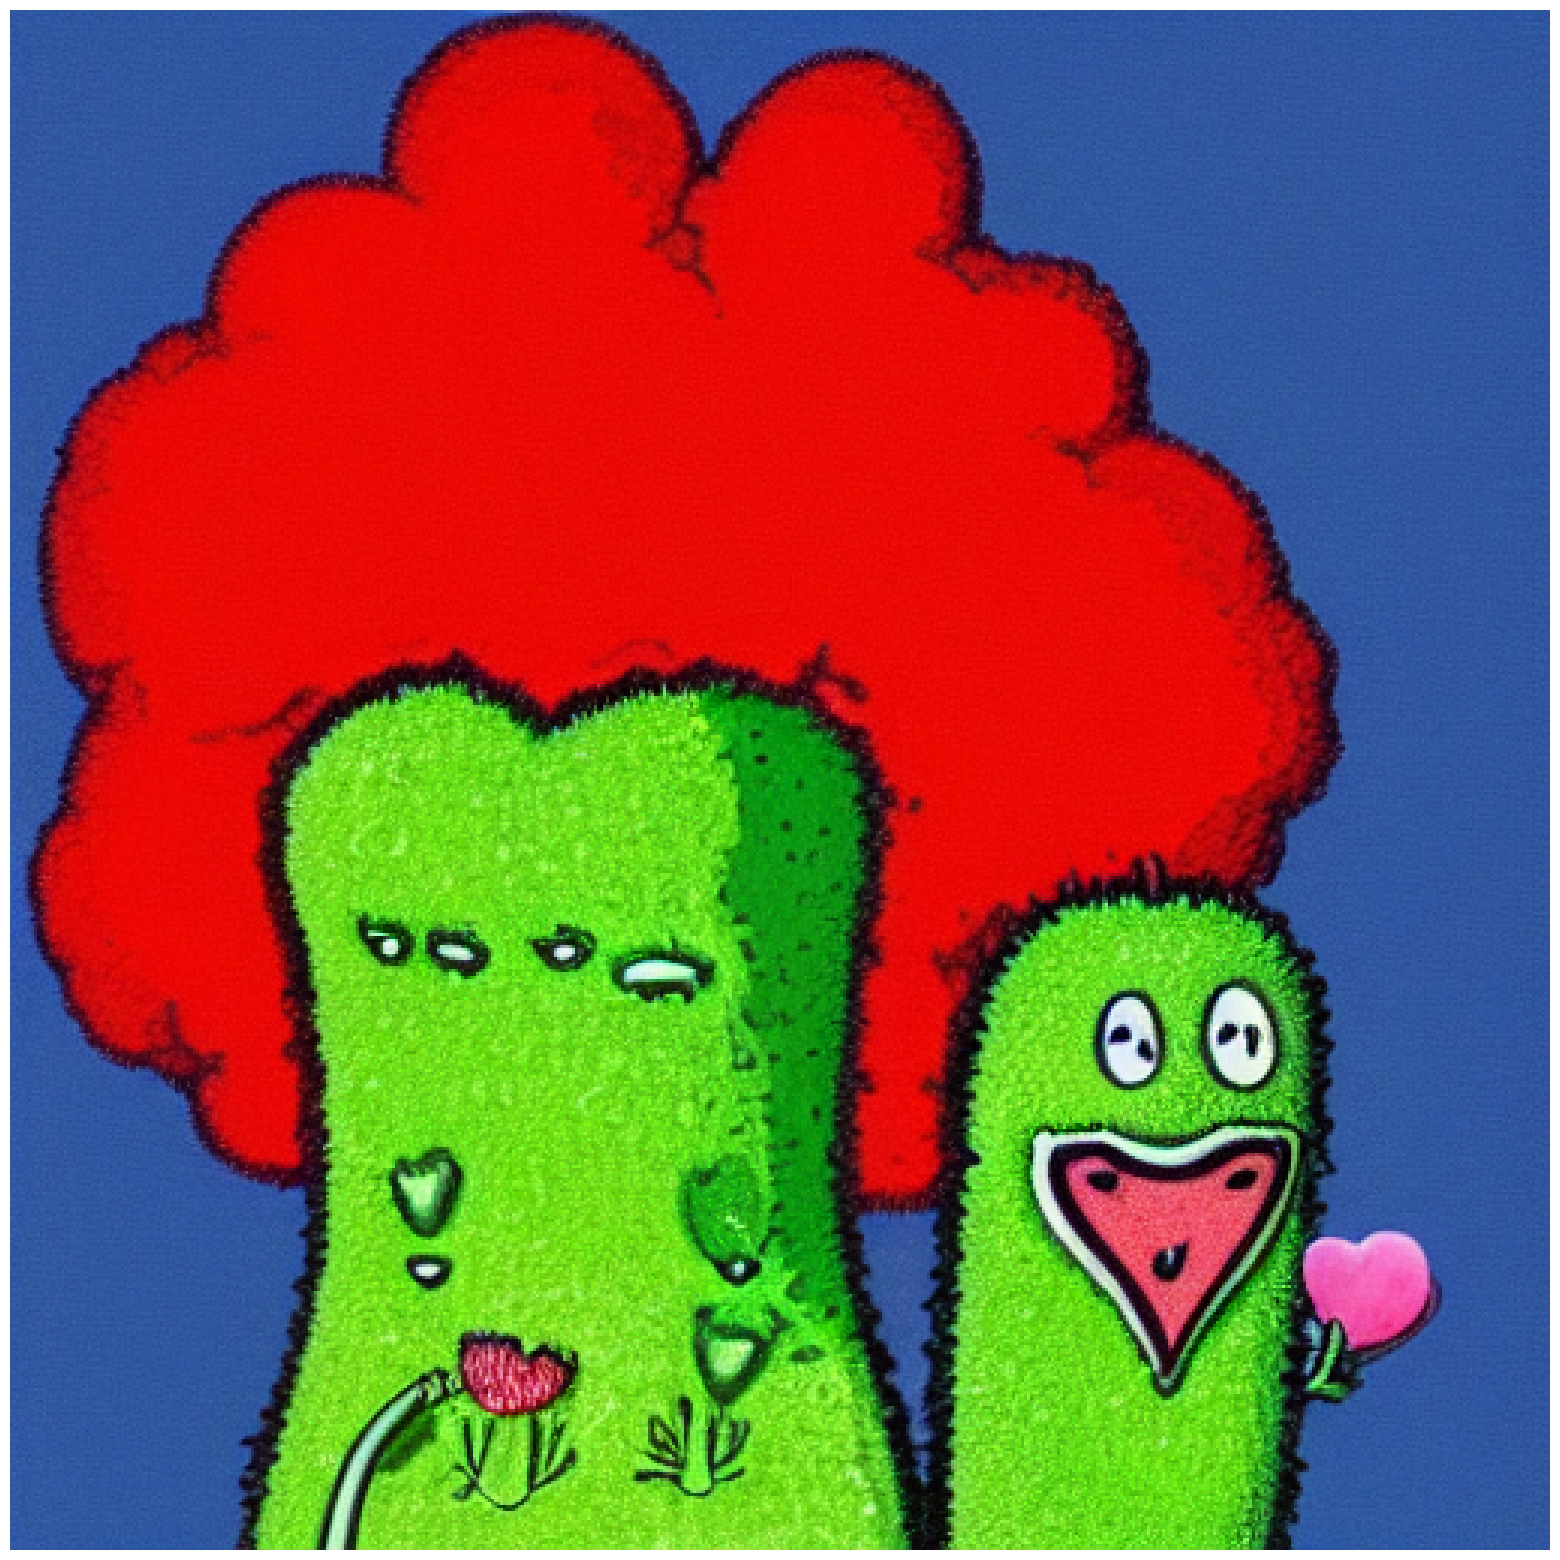

In [ ]:
### how long to train for
epochs = 1
epoch_num = list(range(epochs+1))
txt.training(epochs, stable_diffusion, train_ds, sticker_embedding, cosine_similarity, stable_diffusion, noise_scheduler, training_image_encoder, optimizer, placeholder_token)

In [ ]:
### where to store your newly generated weights
path = '/content/drive/MyDrive/weights_four_emotions.npy'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
### get the weights of the text encoder and save the to Google Drive
text_encoder_weights = np.array(stable_diffusion.text_encoder.get_weights(), dtype=object)

### save the weights array to a file on your Google Drive
np.save(path, text_encoder_weights)

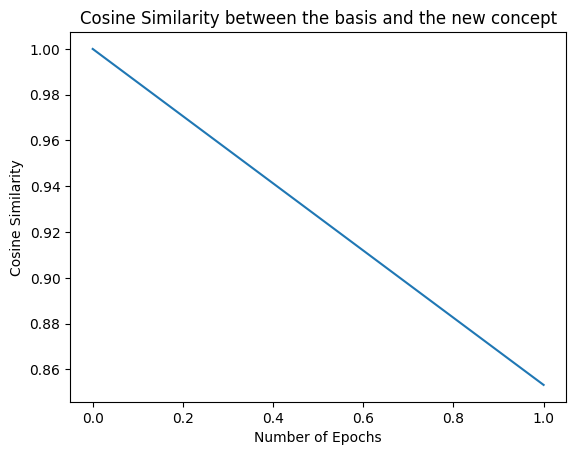

In [ ]:
### plot cosine similarity between old and new embedding
txt.cosine_plot(epoch_num, cosine_similarity)